## 二、使用深度学习进行股价趋势预测
两个基于卷积神经网络的模型
>
    1.全卷积神经网络：FCN
    2.含残差块的卷积神经网络：ResNet

### 2.1 导入相关的包

In [15]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from __future__ import print_function
from collections import Counter
from collections import defaultdict as ddict
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import classification_report
from tensorflow import keras
try:
  import tushare as ts
except:
  # 安装 tushare
  os.system("pip install tushare")
finally:
  import tushare as ts


#### 设置工作路径

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/My Drive/Colab Notebooks/classification_for_trend"
os.chdir(path)
os.listdir(path) # 查看当前工作目录下所有的文件

['前300.csv',
 '大作业_519.ipynb',
 '前300.gsheet',
 '400_700.csv',
 '700_1700.csv',
 'FCN.png',
 'ResNet.png',
 'FCN_for_Trend_Classificatino.ipynb']

### 2.2 数据预处理

#### 加载数据

In [4]:
ori_data = pd.read_csv('前300.csv')
ori_data_alt = pd.read_csv('400_700.csv')
ori_data_alt2 = pd.read_csv('700_1700.csv')
ori_data = pd.concat([ori_data, ori_data_alt, ori_data_alt2], axis=0) # 合并三个表格
print(ori_data.head()) # 打印前五行/五个样本

     ts_code      pc_0      pc_1      pc_2  ...     vc_63     vc_64     vc_65  label
0  000001.SZ -0.018285  0.003854 -0.032630  ...  1.201329 -0.241861  0.015996      1
1  000004.SZ  0.003193  0.000000  0.001061  ...  1.683130 -0.010999 -0.066491      1
2  000004.SZ  0.070625  0.025599  0.004800  ...  0.423950  0.448555 -0.317227      1
3  000005.SZ -0.003802  0.000000  0.022901  ...  0.422602 -0.352756  0.540416      1
4  000006.SZ  0.006234  0.008261  0.002048  ...  0.330381 -0.492307  1.517247      1

[5 rows x 134 columns]


#### 去除数据中含空值列的行

In [16]:
print('原始样本个数：', len(ori_data))
ori_data.dropna(axis=0, how='any', inplace=True)
print('去除含控制样本后的样本个数：', len(ori_data))
print('各类样本个数：（0表示盘整放量，1表示放量上涨，-1表示放量下跌）\n', Counter(ori_data.label))

原始样本个数： 11472
去除含控制样本后的样本个数： 11472
各类样本个数：（0表示盘整放量，1表示放量上涨，-1表示放量下跌）
 Counter({0: 6030, 1: 2872, -1: 2570})


#### 查看各特征及标签的数据类型

In [6]:
ori_data.dtypes

ts_code     object
pc_0       float64
pc_1       float64
pc_2       float64
pc_3       float64
            ...   
vc_62      float64
vc_63      float64
vc_64      float64
vc_65      float64
label        int64
Length: 134, dtype: object

#### 等比例划分训练集和测试(验证)集

In [7]:
train_data = ori_data.values[0::2,]
test_data = ori_data.values[1::2,]
assert len(train_data) + len(test_data) == len(ori_data)

#### 将数据的shape处理成适合CNN输入的形式

In [8]:
x_train_pc, x_train_vc = train_data[:,1:67], train_data[:,67:-1] # feature: price change rate
x_test_pc, x_test_vc = test_data[:,1:67], test_data[:,67:-1] # feature: volume change rate
y_train, y_test = train_data[:,-1], test_data[:,-1] # label
print(x_train_pc.shape)

x_train = np.concatenate((x_train_pc.reshape(x_train_pc.shape+(1,)), x_train_vc.reshape(x_train_vc.shape+(1,))), axis=-1) # price change rate + volume change rate
x_test = np.concatenate((x_test_pc.reshape(x_test_pc.shape+(1,)), x_test_vc.reshape(x_test_vc.shape+(1,))), axis=-1) # price change rate + volume change rate
print(x_train.shape)

x_train = x_train.reshape(x_train.shape[:-1]+(1,)+x_train.shape[-1:]) # (batch_size, rows, columns, channels)
x_test = x_test.reshape(x_test.shape[:-1]+(1,)+x_test.shape[-1:]) # (batch_size, rows, columns, channels)
print(x_train.shape)


nb_classes = len(np.unique(y_test))
assert nb_classes == 3
batch_size = min(x_train.shape[0]/10, 48)

(5736, 66)
(5736, 66, 2)
(5736, 66, 1, 2)


#### 转换数据的类型(np.float64)为np.float32，以适合tensorflow

In [9]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

#### # 将标签从-1,0,1分别转为0,1,2，并用one-hot向量表示

In [10]:
print(y_train)
# 将标签从-1,0,1分别转为0,1,2
y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)
print(y_train)

Y_train = keras.utils.to_categorical(y_train, nb_classes) # 标签转为one-hot 向量
Y_test = keras.utils.to_categorical(y_test, nb_classes) # 标签转为one-hot 向量
print(Y_train)

'''不对数据进行归一化处理'''
# x_train_mean = x_train.mean()
# x_train_std = x_train.std()
# x_train = (x_train - x_train_mean)/(x_train_std)
# x_test = (x_test - x_train_mean)/(x_train_std)

[1 1 1 ... 0 0 0]
[2.0 2.0 2.0 ... 1.0 1.0 1.0]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


'不对数据进行归一化处理'

### 2.3 FCN (Fully Convolutional Network)

#### FCN网络结构
卷积操作由三个大小为{8,5,3}的一维卷积核完成，步幅为1


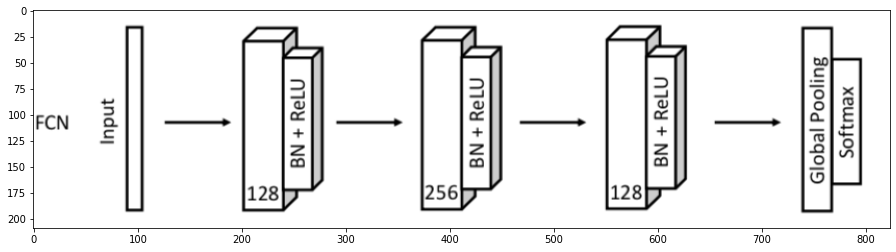

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
fcn_img = plt.imread("FCN.png")
plt.imshow(fcn_img)
plt.show()

#### FCN定义以及模型训练

In [ ]:
nb_epochs = 100

x = keras.layers.Input(x_train.shape[1:])
drop_out1 = keras.layers.Dropout(0.2)(x)
conv1 = keras.layers.Conv2D(128,8,1, padding='same')(drop_out1)
# conv1 = keras.layers.Conv2D(128,8,1, padding='same')(x)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation('relu')(conv1)

drop_out2 = keras.layers.Dropout(0.2)(conv1)
conv2 = keras.layers.Conv2D(256,5,1,padding='same')(drop_out2)
# conv2 = keras.layers.Conv2D(256,5,1,padding='same')(conv1)
Conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('relu')(conv2)

drop_out3 = keras.layers.Dropout(0.2)(conv2)
conv3 = keras.layers.Conv2D(128,3,1,padding='same')(drop_out3)
# conv3 = keras.layers.Conv2D(128,3,1,padding='same')(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('relu')(conv3)
# print(conv3.shape)
full = keras.layers.GlobalAveragePooling2D()(conv3)
out = keras.layers.Dense(nb_classes, activation='softmax')(full)


model = keras.models.Model(inputs=x, outputs=out)

optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                              factor=0.5,
                                              patience=50,
                                              min_lr=0.0001)

with tf.device('/gpu:0'):
    hist = model.fit(x_train, Y_train, batch_size=batch_size,
                    epochs=nb_epochs,
                    verbose=1, validation_data=(x_test, Y_test),
                    callbacks=[reduce_lr], 
                    class_weight={0:2.35,1:1,2:2.1}
                     )
# Print the testing results which has the lowest training loss.
log = pd.DataFrame(hist.history)
print(log.loc[log['loss'].idxmin]['loss'], log.loc[log['loss'].idxmin]['val_accuracy'])
# """

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
120/120 [==============================] - 3s 18ms/step - loss: 1.6862 - accuracy: 0.4477 - val_loss: 1.0104 - val_accuracy: 0.5295
Epoch 2/100
120/120 [==============================] - 2s 14ms/step - loss: 1.5457 - accuracy: 0.5235 - val_loss: 1.0646 - val_accuracy: 0.2509
Epoch 3/100
120/120 [==============================] - 2s 14ms/step - loss: 1.2561 - accuracy: 0.6140 - val_loss: 0.8833 - val_accuracy: 0.6660
Epoch 4/100
120/120 [==============================] - 2s 14ms/step - loss: 1.1202 - accuracy: 0.6426 - val_loss: 0.7530 - val_accuracy: 0.7005
Epoch 5/100
120/120 [==============================] - 2s 14ms/step - loss: 1.0760 - accuracy: 0.6581 - val_loss: 0.8198 - val_accuracy: 0.5762
Epoch 6/100
120/120 [==============================] - 2s 14ms/step - loss: 1.0568 - accuracy: 0.6644 - val_loss: 0.8208 - val_accuracy: 0.579

#### 显示日志

In [ ]:
log

,loss,accuracy,val_loss,val_accuracy,lr
0,1.686201,0.447699,1.010353,0.529463,0.001
1,1.545737,0.523536,1.064593,0.250872,0.001
2,1.256104,0.614017,0.883269,0.665969,0.001
3,1.120175,0.642608,0.753045,0.700488,0.001
4,1.075990,0.658124,0.819752,0.576186,0.001
...,...,...,...,...,...
95,0.791291,0.734135,0.540964,0.761158,0.001
96,0.798126,0.733787,0.532199,0.764819,0.001
97,0.804744,0.741806,0.571775,0.735530,0.001
98,0.803057,0.731520,0.510334,0.772490,0.001


#### 最小训练误差，最小训练误差下的验证准确率

In [ ]:
print(log.loc[log['loss'].idxmin]['loss'], log.loc[log['loss'].idxmin]['val_accuracy'])

0.7909569144248962 0.76778244972229


#### 最小验证误差，最小验证误差下的验证准确率

In [ ]:
print(log.loc[log['val_loss'].idxmin]['val_loss'], log.loc[log['val_loss'].idxmin]['val_accuracy'])

0.5103335976600647 0.7724895477294922


#### 获取测试样本数据

##### 定义获取样本数据的函数

In [ ]:
def find_instances_and_labels(pro, stocks=None, specified_stocks=None, start_no=0, early_stop=100, time_span_years=2.5, duration=25,
                             times_for_up=1.5, times_for_down=1.5, continuous_slide_days=4, continuous_up_days=4,
                             three_trans_day_times=0.05, one_trans_day_times=0.00, days_back_required=66, plain_number=6):
    '''
    Arguments:
        pro: tushare获取数据的接口
        stocks: 含股票代码信息的可迭代容器, None or container
        specified_stocks: 指定的股票代码, None or an container (注意：stocks、specified_stocks不能同时为None)
        start_no: 初始股票大代码索引
        early_stop: 查询股票代码的个数上限
        time_span_years: 获取多少年前至今的日线行情数据
        duration: 股票(几乎在)连续上涨或下跌的最短时间
        times_for_up: 股票上涨后价格至少是上涨前价格的多少倍
        times_for_down: 股票下跌前至少是股票下跌后的多少倍
        continuous_slide_days: 在股票价格趋势为上涨阶段，不能被允许连续下跌的交易天数临界值
        continuous_up_days: 在股票价格趋势为下跌阶段，不能被允许连续下跌的交易天数临界值
        three_trans_day_times: 在股票价格连续上涨阶段，上涨初期后三个交易日的价格至少比初期价格上涨多少(比率)，用于修正上涨初期交易日
        one_trans_day_times: 在股票价格连续下降阶段，下降初期后一天的价格至少比下降初期的价格下降多少(比率)，用于修正下跌初期交易日
        days_back_required: 最后获取的数据是价格上涨初期或价格下跌初期或普通期前多少个交易日的数据
        plain_number: 单只股票最多获取普通例的个数。通常情况，普通例的个数比反常例(正例及负例)多。
    Returns:
        results: 含正例、负例即普通例数据的字典，数据包含股票代码，初期日的索引及交易日期
        outs: 含正例、负例即普通例数据的字典，数据包含股票代码及66(有些不足66)个交易日的trade_date, close, vol, vol_change, price_change
    '''
    start_date = datetime.today() - relativedelta(months=time_span_years*12)
    start_date = start_date.strftime('%Y%m%d')
    results = {'positive':{}, 'negative':{}, 'plain':{}}
    outs = {'positive':ddict(list), 'negative':ddict(list), 'plain':ddict(list)}
    try:
        queried_stock = stocks[start_no:] if specified_stocks is None else specified_stocks
    except:
        raise Exception('stocks and specified_stocks can not be None simultaneously!')
    for nnn, sk in enumerate(queried_stock):
        temp_res_pos = ddict(list)
        temp_res_neg = ddict(list)
        df = ts.pro_bar(api=pro, ts_code=sk, start_date=start_date, adj='qfq')
        if len(df) < 120:
            continue
        df = df[['ts_code', 'trade_date', 'close', 'vol']].sort_values(by='trade_date', ascending=True)
        df.reset_index(drop=True, inplace=True)
        # 标记涨跌情况
        df['up'] = (df['close']-df['close'].shift(1)) > 0
        df['down'] = (df['close']-df['close'].shift(1)) < 0
        # 计算成交量变化
        df['vol_change'] = (df['vol'] - df['vol'].shift(1))/df['vol'].shift(1)
        df['price_change'] = (df['close'] - df['close'].shift(1))/df['close'].shift(1)
        
        '''find negative instances'''
        found_neg = False # 初始化
        count_neg = 0 # 初始化
        temp_start_indices_neg = []
        for n, p in enumerate(df.close):
            if found_neg:
                if count_neg < duration:
                    count_neg += 1
                    continue
            count_neg = 0
            found_neg = False
            try:
                if df.loc[n, 'close']/df.loc[n+duration, 'close'] >= times_for_down and n >= 3:
                    invalid_neg = False
                    for k, up in enumerate(df.iloc[n:n+duration-continuous_up_days, 4]):
                        if sum(df.iloc[k+n:k+n+continuous_up_days, 4]) == continuous_up_days:
                            invalid_neg = True
                            break
                    if not invalid_neg:
                        found_neg = True
                        # 试图找到更加合适的大跌起始日
                        adding_days_neg = 0
                        for tt in range(duration):
                            if (df.loc[n+tt, 'close'] - df.loc[n+tt-1, 'close'])/df.loc[n+tt-1, 'close']  > -one_trans_day_times:
                                adding_days_neg += 1
                            else:
                                break
                        temp_res_neg[sk].append((n+adding_days_neg, df.loc[n+adding_days_neg, 'trade_date']))
            except: # 索引越界
                break
        if len(temp_res_neg):
            results['negative'].update(temp_res_neg)
            for val in temp_res_neg[sk]:
                temp_start_index_neg = val[0] - days_back_required if val[0] - days_back_required >= 0 else 0
                temp_start_indices_neg.append(temp_start_index_neg)
                if temp_start_index_neg >= val[0] - 1:
                    pass
                else:
                    outs['negative'][sk].append(df.values[temp_start_index_neg+3:val[0]+3, [1,2,3,6,7]]) # 保留的特征： trade_date, close, vol, vol_change, price_change
       
        '''find positive instances'''
        found_pos = False # 初始化
        count_pos = 0 # 初始化
        temp_start_indices_pos = []
        for n, p in enumerate(df.close):
            if found_pos:
                if count_pos < duration:
                    count_pos += 1
                    continue
            count_pos = 0
            found_pos = False
            try:
                if df.loc[n+duration, 'close']/df.loc[n, 'close'] >= times_for_up and n >= 3:
                    invalid_pos = False
                    for kk, fall in enumerate(df.iloc[n:n+duration-continuous_slide_days, 5]):
                        if sum(df.iloc[kk+n:kk+n+continuous_slide_days, 5]) == continuous_slide_days:
                            invalid_pos = True
                            break
                    if not invalid_pos:
                        found_pos = True
                        # 试图找到更加合适的大跌起始日
                        adding_days_pos = 0
                        for ttt in range(duration):
                            if df.loc[n+ttt, 'vol_change'] < 0.2:
                                adding_days_pos += 1
                            else:
                                break
                        temp_res_pos[sk].append((n+adding_days_pos, df.loc[n+adding_days_pos, 'trade_date']))
            except: # 索引越界
                break
        if len(temp_res_pos):
            results['positive'].update(temp_res_pos)
            for val in temp_res_pos[sk]:
                temp_start_index_pos = val[0] - days_back_required if val[0] - days_back_required >= 0 else 0
                temp_start_indices_pos.append(temp_start_index_pos)
                if temp_start_index_pos >= val[0] - 1:
                    pass
                else:
                    outs['positive'][sk].append(df.values[temp_start_index_pos+3:val[0]+3, [1,2,3,6,7]]) # 保留的特征： trade_date, close, vol, vol_change, price_change
        
        '''find plain instances'''
        # 寻找空当，既不是底部放量价格大幅上升阶段，也不是价格大幅下降阶段
        temp_available_date_interval = []
        # 价格大幅上升或价格大幅下降起始点的前days_back_required个交易日以及后duration个交易日已经被占用
        combined_start_indices = sorted([y for x in [temp_start_indices_neg, temp_start_indices_pos] for y in x])
        
        if len(combined_start_indices):
            last_index = 0 # 初始化
            for st in combined_start_indices:
                if (st-days_back_required) - (last_index+duration) >= days_back_required:
                    temp_available_date_interval.append((last_index+duration, st-days_back_required))
                    last_index = st
                else:
                    pass
            if len(df) - 1 - combined_start_indices[-1]+duration >= 2*days_back_required:
                temp_available_date_interval.extend([(i, i+days_back_required) for i in range(combined_start_indices[-1]+duration, len(df), days_back_required)])
        else:
            temp_available_date_interval = [(i, i+days_back_required) for i in range(0, len(df), days_back_required)]
            
        if temp_available_date_interval[-1][1] >= len(df):
            # 索引越界
            temp_available_date_interval.pop()
            
        if len(temp_available_date_interval):
            chose_plain_interval_indices = sorted(np.random.choice(range(len(temp_available_date_interval)), plain_number, replace=False)) \
                if len(temp_available_date_interval) > plain_number else list(range(len(temp_available_date_interval)))
#             for plain_interval_index in chose_plain_interval_indices:
            results['plain'].update({sk:[(temp_available_date_interval[index][1], df.loc[temp_available_date_interval[index][1], 'trade_date']) \
                                         for index in chose_plain_interval_indices]})
            outs['plain'][sk].extend([df.values[temp_available_date_interval[index][1]-days_back_required:temp_available_date_interval[index][1], [1,2,3,6,7]] \
                                         for index in chose_plain_interval_indices])
        else:
            pass
        
        if early_stop and specified_stocks is None:
            if nnn >= early_stop:
#                 print(results)
                return results, outs
            
#     print(results)
    return results, outs

##### 获取所有上市股票代码

In [ ]:
pro = ts.pro_api('6ddbb5d15f9a2483d319b19fb0d973e677b25d1507b0b98539c272d8')
stocks_b = pro.query('stock_basic', exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')
all_stock = stocks_b['ts_code']
all_stock

0       000001.SZ
1       000002.SZ
2       000004.SZ
3       000005.SZ
4       000006.SZ
          ...    
4305    688777.SH
4306    688788.SH
4307    688819.SH
4308    688981.SH
4309    689009.SH
Name: ts_code, Length: 4310, dtype: object

##### 获取测试样本数据

In [ ]:
res_all, out_all = find_instances_and_labels(pro, stocks=all_stock, start_no=300, early_stop=100, times_for_up=1.3, times_for_down=1.3)

##### 显示测试样本数据基本信息

In [ ]:
res_all

{'negative': {'000788.SZ': [(76, '20190325')],
  '000789.SZ': [(84, '20190404')],
  '000791.SZ': [(511, '20210105')],
  '000793.SZ': [(77, '20190326'),
   (376, '20200617'),
   (489, '20201203'),
   (575, '20210413')],
  '000795.SZ': [(121, '20190531')],
  '000796.SZ': [(93, '20190418'),
   (260, '20191223'),
   (393, '20200714'),
   (443, '20200922'),
   (489, '20201203')],
  '000797.SZ': [(84, '20190404')],
  '000798.SZ': [(409, '20200805'), (505, '20201225'), (576, '20210414')],
  '000799.SZ': [(534, '20210205')],
  '000800.SZ': [(83, '20190418')],
  '000802.SZ': [(84, '20190404'),
   (310, '20200311'),
   (336, '20200417'),
   (431, '20200904'),
   (486, '20201130'),
   (572, '20210408')],
  '000803.SZ': [(138, '20190708'), (243, '20191223')],
  '000806.SZ': [(69, '20190314'), (94, '20190422'), (326, '20200403')],
  '000807.SZ': [(491, '20201207')],
  '000810.SZ': [(299, '20200225')],
  '000811.SZ': [(143, '20190703'), (507, '20201229')],
  '000812.SZ': [(87, '20190410'), (143, '20

In [ ]:
{key:value for no,(key,value) in enumerate(out_all['positive'].items()) if no < 2}

{'000788.SZ': [array([['20181203', 5.6634, 52995.58, 0.6172375279225616,
          0.030852399934472818],
         ['20181204', 5.7332, 33881.92, -0.3606651724540047,
          0.012324751915810266],
         ['20181205', 5.6833, 36103.86, 0.06557892823074969,
          -0.008703690783506603],
         ['20181206', 5.7332, 91432.68, 1.532490431771007,
          0.0087801101472736],
         ['20181207', 5.5238, 82486.8, -0.09784116576261344,
          -0.036524105211749196],
         ['20181210', 5.3044, 46615.65, -0.43487139760543503,
          -0.03971903399833437],
         ['20181211', 5.3044, 26327.59, -0.4352199315036903, 0.0],
         ['20181212', 5.2944, 19986.26, -0.24086253242321085,
          -0.001885227358419385],
         ['20181213', 5.3642, 28714.26, 0.43670001290886845,
          0.013183741311574466],
         ['20181214', 5.2546, 18977.81, -0.33908065191302156,
          -0.020431751239700303],
         ['20181217', 5.2246, 15646.02, -0.17556240683197907,
          

##### 删除含空值的测试样本

In [ ]:
data_to_test = []
count_omiteed = 0
dd = {'positive':1, 'negative':-1, 'plain':0}
for key, values in out_all.items():
    for code, vals in values.items():
        for val in vals:
            if np.isnan(val[0,-1]):
              print('omitted')
              count_omiteed += 1
              continue
            if len(val) == 66:
                data_to_test.append([y for x in [[code], list(val[:,-1]), list(val[:,-2]), [dd[key]]] for y in x])
print('omitted number:', count_omiteed)

omitted
omitted
omitted
omitted
omitted
omitted number: 5


##### 将测试样本数据转为适合模型输入的格式

In [ ]:
data_to_test = np.array(data_to_test)
print(data_to_test.shape)

new_x_test_pc, new_x_test_vc = data_to_test[:,1:67], data_to_test[:,67:-1]
new_y_test = data_to_test[:,-1].astype(np.int32) # 字符型转为整型

new_x_test = np.concatenate((new_x_test_pc.reshape(new_x_test_pc.shape+(1,)), new_x_test_vc.reshape(new_x_test_vc.shape+(1,))), axis=-1)
print(new_x_test.shape)

new_x_test = new_x_test.reshape(new_x_test.shape[:-1]+(1,) + new_x_test.shape[-1:])
print(new_x_test.shape)
new_x_test = new_x_test.astype(np.float32) # float64转为float32

(708, 134)
(708, 66, 2)
(708, 66, 1, 2)


#### 用模型预测测试样本数据的标签

In [ ]:
hist.model.predict(new_x_test).argmax(axis=-1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 2, 1, 2,
       1, 1, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2,
       1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 2, 0, 0,

#### 查看模型预测效果

In [ ]:
print(classification_report(new_y_test+1, hist.model.predict(new_x_test).argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78       161
           1       0.82      0.73      0.78       365
           2       0.67      0.84      0.75       182

    accuracy                           0.77       708
   macro avg       0.77      0.78      0.77       708
weighted avg       0.78      0.77      0.77       708



##### 定义新的评价标准，给不同的类赋予不同的权重

In [ ]:
def score(p_1, p_2, p_3):
    return p_1 * 0.4 + p_2 * 0.2 + p_3 * 0.4

In [ ]:
report = classification_report(new_y_test+1, hist.model.predict(new_x_test).argmax(axis=-1), output_dict=True)

In [ ]:
score(report['0']['f1-score'], report['1']['f1-score'], report['2']['f1-score'])

0.7683280362106681

#### 简单的调参过程记录
数据量未加倍：0.6174705072382867(none of class_weight)  
数据量未加倍：0.6954985754985755(class_weight)  
数据量加倍：0.6930637718357805  
数据量加至5倍：0.7657705578516697  
数据量加至5倍：0.7233109553223769(none of class_weight)  
数据量加至5倍：0.7683280362106681(class_weight={0:2.35,1:1,2:2.1})

### 2.4 ResNet

#### ResNet网络结构
堆叠了三个残差块，然后是一个全局平均池化层和一个 softmax 层

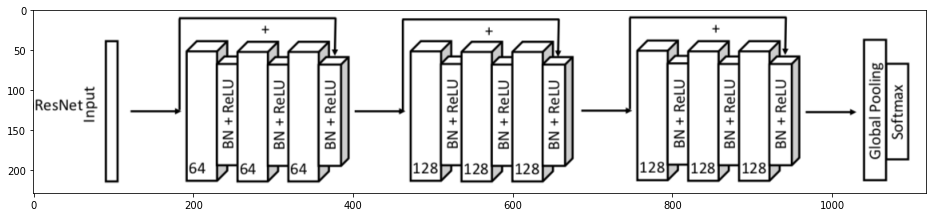

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
fcn_img = plt.imread("ResNet.png")
plt.imshow(fcn_img)
plt.show()

#### ResNet定义

In [ ]:
def build_resnet(input_shape, n_feature_maps, nb_classes, dropout=[0.2, 0.2]):
  '''
  dropout: list; the first element represents whether uses dropout outside the block,
                 the  second element represents whether uses dropout inside the block.
  '''
  print('build conv_x')
  x = keras.layers.Input(shape=(input_shape))
  if dropout[0]:
    drop_out1 = keras.layers.Dropout(dropout[0])(x)
    conv_x = keras.layers.BatchNormalization()(drop_out1)
  else:
    conv_x = keras.layers.BatchNormalization()(x)
  conv_x = keras.layers.Conv2D(n_feature_maps, 8, 1, padding='same')(conv_x)
  conv_x = keras.layers.BatchNormalization()(conv_x)
  conv_x = keras.layers.Activation('relu')(conv_x)

  print('build conv_y')
  if dropout[1]:
    conv_x = keras.layers.Dropout(dropout[1])(conv_x)
  conv_y = keras.layers.Conv2D(n_feature_maps, 5, 1, padding='same')(conv_x)
  conv_y = keras.layers.BatchNormalization()(conv_y)
  conv_y = keras.layers.Activation('relu')(conv_y)

  print('build conv_z')
  if dropout[1]:
    conv_y = keras.layers.Dropout(dropout[1])(conv_y)
  conv_z = keras.layers.Conv2D(n_feature_maps, 3, 1, padding='same')(conv_y)
  conv_z = keras.layers.BatchNormalization()(conv_z)

  is_expand_channels = not (input_shape[-1] == n_feature_maps)
  if is_expand_channels:
    shortcut_y = keras.layers.Conv2D(n_feature_maps, 1, 1, padding='same')(x)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
  else:
    shortcut_y = keras.layers.BatchNormalization()(x)
  print('Merging skip connection')
  y = keras.layers.Add()([shortcut_y, conv_z])
  y = keras.layers.Activation('relu')(y)

  print('build conv_x')
  x1 = y
  if dropout[0]:
    drop_out2 = keras.layers.Dropout(dropout[0])(x1)
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(drop_out2)
  else:
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
  conv_x = keras.layers.BatchNormalization()(conv_x)
  conv_x = keras.layers.Activation('relu')(conv_x)

  print ('build conv_y')
  if dropout[1]:
    conv_x = keras.layers.Dropout(dropout[1])(conv_x)
  conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
  conv_y = keras.layers.BatchNormalization()(conv_y)
  conv_y = keras.layers.Activation('relu')(conv_y)

  print ('build conv_z')
  if dropout[1]:
    conv_y = keras.layers.Dropout(dropout[1])(conv_y)
  conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
  conv_z = keras.layers.BatchNormalization()(conv_z)

  is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
  if is_expand_channels:
      shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
      shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
  else:
      shortcut_y = keras.layers.BatchNormalization()(x1)
  print ('Merging skip connection')
  y = keras.layers.Add()([shortcut_y, conv_z])
  y = keras.layers.Activation('relu')(y)

  print ('build conv_x')
  x1 = y
  if dropout[0]:
    drop_out3 = keras.layers.Dropout(dropout[0])(x1)
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(drop_out3)
  else:
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
  conv_x = keras.layers.BatchNormalization()(conv_x)
  conv_x = keras.layers.Activation('relu')(conv_x)
  
  print ('build conv_y')
  if dropout[1]:
    conv_x = keras.layers.Dropout(dropout[1])(conv_x)
  conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
  conv_y = keras.layers.BatchNormalization()(conv_y)
  conv_y = keras.layers.Activation('relu')(conv_y)
    
  print ('build conv_z')
  if dropout[1]:
    conv_y = keras.layers.Dropout(dropout[1])(conv_y)
  conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
  conv_z = keras.layers.BatchNormalization()(conv_z)

  is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
  if is_expand_channels:
      shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
      shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
  else:
      shortcut_y = keras.layers.BatchNormalization()(x1)
  print ('Merging skip connection')
  y = keras.layers.Add()([shortcut_y, conv_z])
  y = keras.layers.Activation('relu')(y)

  full = keras.layers.GlobalAveragePooling2D()(y)
  out = keras.layers.Dense(nb_classes, activation='softmax')(full)
  print('       -- model was built.')
  return x, out

#### 训练ResNet

In [ ]:
nb_epochs = 100
x, y = build_resnet(x_train.shape[1:], 64, nb_classes, dropout=[0.2, 0.2])
model = keras.models.Model(inputs=x, outputs=y)
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                                              patience=50, min_lr=0.0001)

'''
with tf.device('/gpu:0'):
    hist = model.fit(x_train, Y_train, batch_size=batch_size,
                    epochs=nb_epochs,
                    verbose=1, validation_data=(x_test, Y_test),
                    callbacks=[reduce_lr], 
                     class_weight={0:2.9,1:1,2:2.5}
                     )
'''
with tf.device('/gpu:0'):
    hist_RN = model.fit(x_train, Y_train, batch_size=batch_size,
                        epochs=nb_epochs,
                        verbose=1, validation_data=(x_test, Y_test),
                        callbacks=[reduce_lr],
                        class_weight={0:2.35,1:1,2:2.1}
                        )

build conv_x
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
       -- model was built.
Epoch 1/100
120/120 [==============================] - 6s 40ms/step - loss: 1.5963 - accuracy: 0.4864 - val_loss: 1.0668 - val_accuracy: 0.5256
Epoch 2/100
120/120 [==============================] - 4s 35ms/step - loss: 1.1728 - accuracy: 0.6189 - val_loss: 1.0134 - val_accuracy: 0.5694
Epoch 3/100
120/120 [==============================] - 4s 35ms/step - loss: 0.9904 - accuracy: 0.6778 - val_loss: 0.8173 - val_accuracy: 0.6257
Epoch 4/100
120/120 [==============================] - 4s 36ms/step - loss: 0.9482 - accuracy: 0.6935 - val_loss: 0.7656 - val_accuracy: 0.6634
Epoch 5/100
120/120 [==============================] - 4s 36ms/step - loss: 0.8901 - accuracy: 0.7111 - val_loss: 0.5352 - val_accuracy: 0.7585
Epoch 6/100
120/120 [==============================] - 4s 36ms/s

#### 最小训练误差，最小训练误差下的验证准确率

In [ ]:
log_RN = pd.DataFrame(hist_RN.history)
print(log_RN.loc[log_RN['loss'].idxmin]['loss'], log_RN.loc[log_RN['loss'].idxmin]['val_accuracy'])

0.13523869216442108 0.7517433762550354


#### 最小验证误差，最小验证误差下的验证准确率

In [ ]:
print(log_RN.loc[log_RN['val_loss'].idxmin]['val_loss'], log_RN.loc[log_RN['val_loss'].idxmin]['val_accuracy'])

0.47541508078575134 0.7862622141838074


#### 显示日志

In [ ]:
log_RN

,loss,accuracy,val_loss,val_accuracy,lr
0,1.596272,0.486402,1.066804,0.525628,0.001
1,1.172823,0.618898,1.013432,0.569386,0.001
2,0.990371,0.677824,0.817268,0.625697,0.001
3,0.948174,0.693515,0.765607,0.663354,0.001
4,0.890060,0.711123,0.535230,0.758543,0.001
...,...,...,...,...,...
95,0.143449,0.957810,0.993087,0.759066,0.001
96,0.138227,0.961471,1.021060,0.750000,0.001
97,0.135239,0.963040,0.987809,0.751743,0.001
98,0.137774,0.962692,0.950524,0.758020,0.001


#### 用模型预测测试样本的标签

In [ ]:
hist_RN.model.predict(new_x_test).argmax(axis=-1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       1, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 2, 0, 0,

#### 测试样本的真实标签

In [ ]:
new_y_test+1

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### 查看模型预测效果

In [ ]:
print(classification_report(new_y_test+1, hist_RN.model.predict(new_x_test).argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       161
           1       0.86      0.68      0.76       365
           2       0.67      0.91      0.77       182

    accuracy                           0.76       708
   macro avg       0.75      0.79      0.76       708
weighted avg       0.78      0.76      0.76       708



In [ ]:
report_RN = classification_report(new_y_test+1, hist_RN.model.predict(new_x_test).argmax(axis=-1), output_dict=True)

##### 在新的评价标准下(给予不同类别不同的权重)，模型预测的效果

In [ ]:
score(report_RN['0']['f1-score'], report_RN['1']['f1-score'], report_RN['2']['f1-score'])

0.761763303536615

#### 简单的调参过程记录
class_weight = None
>>
  dropout=[0.2, 0.2]-> 0.736473900429494  
  dropout=[0.2, 0.3]-> 0.7006760867268349  
  dropout=[0.3, 0.2]-> 0.6908787239942282  
  dropout=[0.2, 0.25]-> 0.710606528672195

class_weight = {0:2.9,1:1,2:2.5}
>>
  dropout=[0.2, 0.2]-> 0.7297569942130396


数据量加倍
>>
  class_weight = {0:2.77,1:1,2:2.3}  
  dropout=[0.2, 0.2]-> 0.7005164064022427

数据量加至5倍：
>>
  class_weight = {0:2.77,1:1,2:2.3}  
  dropout=[0.2, 0.2]-> 0.7430938760496404  
  class_weight = None  
  dropout=[0.2, 0.2]-> 0.7304022731576931  
  class_weight = {0:2.35,1:1,2:2.1}  
  dropout=[0.2, 0.2]-> 0.761763303536615  


### 2.5 两个神经网络模型预测效果对比分析
>
    RetNet在通过残差连接增加了网络层数的情况下，预测效果和FCN相差无几
    ResNet对于标签为盘整放量的样本的预测效果略优于FCN
    FCN对于标签为放量下跌的样本的预测效果略优于ResNet
    FCN和ResNet对于标签为放量上涨的样本预测准确率较一般
    FCN和ResNet对于标签为放量上涨的样本预测召回率较好，尤其是ResNet(recall = 0.91)

## 本此实践结论&不足&展望

### 结论
>
    集成模型在特定任务上可以匹敌深度学习模型；
    当预测概率在0.75以上时，预测结果的可信度极高 (当然还需要更多样本进行验证) ，但这种情况较少。

### 不足
>
    样本的选取可能需要继续完善，特别是对于类标号为1的样本 (表示盘整放量) 的选取需要进一步优化；
    可以考虑增加标签个数(不只是只有三类)；
    在以上基础之上可以考虑增加特征 (如文本特征) ，使得模型的预测效果更好。

### 展望
>
    可以考虑使用其他深度学习模型，例如循环神经网络与卷积神经网络的结合，加入Attention机制等。